## Classification of the MNIST data

In [1]:
import tensorflow as tf
import numpy as np
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


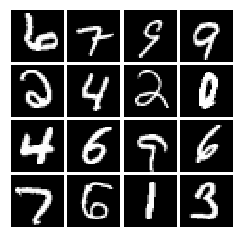

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
show_images(mnist.train.next_batch(16)[0])

### The general structure of this classifier
**1.** Conv-layer1 with filter $5 \times 5 \times 1 \times 32$  
**2** Relu  
**3** Max Pooling with filter $2 \times 2$ stride $2 \times 2$  
**4** Conv-layer2 with filter $5 \times 5 \times 32 \times 64$  
**5** Relu  
**6** Max Pooling with filter $2 \times 2$ stride $2 \times 2$  
**7** Fully Connected layer1 from dimension $7\times7\times64$ to 1024  
**8** Dropout layer, with dropout probability 0.7  
**9** Fully connected layer, form dimension 1024 to 10  
**10** Softmax  
The loss function is the cross entropy, and Adam Optimizer is used to train.  


In [4]:
batch_size = 128
# num_batches = mnist.train.num_examples // batch_size


x = tf.placeholder(tf.float32, [None, 784], name = 'x_input')
y = tf.placeholder(tf.float32, [None, 10], name = 'y_input')
# initialize
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

#  define conv layers
def conv2d(x, W):
#     input tensor of shape '[batch, in_height, in_width, in_channels]'
#     W filter / kernel tensor of shape '[filter_height, filter_width, in_channels, out_channels]'
#     stride[0] = stride[3] = 1, strides[1] is the stride in x direction, strides[2] is the stride in y direction.
    return tf.nn.conv2d(x, W, strides = [1,1,1,1,], padding = 'SAME')

# pooling layers
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')



# Change x into proper dimensions
x_image = tf.reshape(x, [-1, 28, 28, 1])

# initialized the filters and biases
W_conv1 = weight_variable([5, 5, 1, 32])# height 5, width 5, depth 1, channels 32
b_conv1 = bias_variable([32])# a bias for each filter

# convolution + bias + relu
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])# height 5, width 5, depth 1, channels 32
b_conv2 = bias_variable([64])# a bias for each filter

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# fully connected layer
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])

# flatten the outcome before the fully connected layer
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

# out of the first fully connected layer
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# do some dropout to regularize
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# the second fullu connected layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

# calculate the final outcome
prediction = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

with tf.name_scope ('CrossEntropy'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = prediction))
    tf.summary.scalar('CrossEntropy', cross_entropy)

#loss = tf.reduce_mean(tf.square(y - out1))
train = tf.train.AdamOptimizer(5e-4).minimize(cross_entropy)

# store the prediction in bool format
correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

#calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
merged = tf.summary.merge_all()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#     writer = tf.summary.FileWriter('C:/Users/leo/Documents/Courses/Neural Network and AI/Final Exam/Problem 5/log/', sess.graph)
#     for epoch in range(1):
    for batch in range(500):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        sess.run(train, feed_dict = {x: batch_xs, y: batch_ys, keep_prob: 0.7})
#         summ, _ = sess.run(merged, feed_dict = {x: batch_xs, y: batch_ys, keep_prob: 0.7})
#         writer.add_summary(summ, batch)
        if batch%10 == 0:
            Entropy = sess.run(cross_entropy, feed_dict = {x: batch_xs, y: batch_ys, keep_prob: 0.7})
            print("Batch " + str(batch) + ", Cross_entropy= " + str(Entropy))
            acc = sess.run(accuracy, feed_dict = {x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})   
            print("Batch " + str(batch) + ", Testing accuracy= " + str(acc))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Batch 0, Cross_entropy= 7.5035515
Batch 0, Testing accuracy= 0.1921
Batch 10, Cross_entropy= 2.422924
Batch 10, Testing accuracy= 0.5853
Batch 20, Cross_entropy= 0.84279406
Batch 20, Testing accuracy= 0.8142
Batch 30, Cross_entropy= 0.62937295
Batch 30, Testing accuracy= 0.8548
Batch 40, Cross_entropy= 0.51188385
Batch 40, Testing accuracy= 0.9013
Batch 50, Cross_entropy= 0.45346874
Batch 50, Testing accuracy= 0.9195
Batch 60, Cross_entropy= 0.3295034
Batch 60, Testing accuracy= 0.9274
Batch 70, Cross_entropy= 0.306209
Batch 70, Testing accuracy= 0.935
Batch 80, Cross_entropy= 0.15366
Batch 80, Testing accuracy= 0.9407
Batch 90, Cross_entropy= 0.13691728
Batch 90, Testing accuracy= 0.9463
Batch 100, Cross_entropy= 0.320243
Batch 100, Testing accuracy= 0.9493
Batch 110, Cross_entropy= 0.21963564
Ba